In [1]:
import numpy as np
np.seterr(all='ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from scipy.stats import binned_statistic

from my_functions import *
from load_mocks import ensemble_mock
from minijpas_LF_and_puricomp import add_errors, nb_or_3fm_cont, compute_L_Lbin_err

In [2]:
%matplotlib inline

In [3]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))
w_lya = 1215.67
filter_tags = load_filter_tags()

In [4]:
sf_frac = 0.1
qso_LAE_frac = 1

gal_area = 3
bad_qso_area = 400
good_qso_area = 400 * qso_LAE_frac
sf_area = 200 * sf_frac

name_qso_bad = 'QSO_LAES'
name_qso = 'QSO_contaminants'
name_gal = f'GAL_LC_lines_0'
name_sf = f'LAE_12.5deg_z2-4.25_train_minijpas_VUDS_0'

pm_flx, pm_err, zspec, EW_lya, L_lya, is_qso, is_sf, is_gal,\
    is_LAE, where_hiL, _, L_NV, EW_NV, _, _ =\
    ensemble_mock(name_qso, name_gal, name_sf, name_qso_bad,
                  add_errs=False, sf_frac=sf_frac, qso_LAE_frac=qso_LAE_frac,
                  mag_min=17, mag_max=24)
print(len(is_qso))

L_lya_NV = np.log10(10**L_lya + 10**L_NV)

pm_flx, pm_err = add_errors(pm_flx, apply_err=True,
                            survey_name='minijpasAEGIS001')

where_bad_flx = ~np.isfinite(pm_flx)
pm_flx[where_bad_flx] = 0.
pm_err[where_bad_flx] = 9999999999.

# the proportional factors are made in relation to bad_qso
# so bad_qso_factor = 1
sf_factor = bad_qso_area / sf_area
gal_factor = bad_qso_area / gal_area
good_qso_factor = bad_qso_area / good_qso_area

QSO mock loaded
GAL mock loaded
SFG mock loaded
QSO mock 2 loaded
481564


In [5]:
mag = flux_to_mag(pm_flx[-2], w_central[-2])
mag[np.isnan(mag)] = 99.

N_sources = pm_flx.shape[1]
N_sources
print(f'qso {count_true(is_qso)}')
print(f'sf {count_true(is_sf)}')
print(f'gal {count_true(is_gal)}')

qso 141379
sf 137864
gal 202321


In [6]:
ew0_cut = 30
ew_other = 100

# Cont est
cont_est_lya, cont_err_lya, cont_est_other, cont_err_other =\
        nb_or_3fm_cont(pm_flx, pm_err, 'nb')

# Lya search
line = is_there_line(pm_flx, pm_err, cont_est_lya, cont_err_lya, ew0_cut, sigma=3)
lya_lines, lya_cont_lines, line_widths = identify_lines(
    line, pm_flx, cont_est_lya, first=True, return_line_width=True
)
lya_lines = np.array(lya_lines)

# Other lines
line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other,
    ew_other, obs=True, sigma=5)
other_lines = identify_lines(line_other, cont_est_other, pm_err)

# Compute z
z_Arr = np.zeros(N_sources)
z_Arr[np.where(np.array(lya_lines) != -1)] =\
    z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])

nice_z = np.abs(z_Arr - zspec) < 0.16

mag_min = 17
mag_max = 24

nb_min = 1
nb_max = 24

nbs_to_consider = np.arange(nb_min, nb_max + 1)

nb_cut = (np.array(lya_lines) >= nb_min) & (np.array(lya_lines) <= nb_max)

z_min = (w_central[nb_min] - nb_fwhm_Arr[nb_min] * 0.5) / w_lya - 1
z_max = (w_central[nb_max] + nb_fwhm_Arr[nb_max] * 0.5) / w_lya - 1
print(f'z interval: ({z_min:0.2f}, {z_max:0.2f})')

z_cut = (z_min < z_Arr) & (z_Arr < z_max)
zspec_cut = (z_min < zspec) & (zspec < z_max)
mag_cut = (mag > mag_min) & (mag < mag_max)

snr = np.empty(N_sources)
for src in range(N_sources):
    l = lya_lines[src]
    snr[src] = pm_flx[l, src] / pm_err[l, src]

nice_lya_mask = (lya_lines >= nb_min) & (lya_lines <= nb_max) & mag_cut & (snr > 6)
nice_lya = nice_lya_select(
    lya_lines, other_lines, pm_flx, pm_err, cont_est_lya, z_Arr, mask=nice_lya_mask
)
print(sum(nice_lya))

EW_nb_Arr, EW_nb_e, L_Arr_uncorr, L_e_Arr, flambda, flambda_e = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, N_nb=0
)

# Compute and save L corrections and errors
L_binning = np.logspace(40, 47, 25 + 1)
L_bin_c = [L_binning[i: i + 2].sum() * 0.5 for i in range(len(L_binning) - 1)]
Lmask = nice_z & nice_lya & (L_lya > 42) & is_qso
L_Lbin_err_plus, L_Lbin_err_minus, median_L = compute_L_Lbin_err(
    L_Arr_uncorr[Lmask], L_lya[Lmask], L_binning
)

mask_median_L = (median_L < 10)
corr_L = np.interp(L_Arr_uncorr, np.log10(L_bin_c)
                   [mask_median_L], median_L[mask_median_L])
# Correct L_Arr with the median
L_Arr = L_Arr_uncorr - corr_L

z interval: (2.05, 4.09)
45126


In [7]:
# Apply bin err
L_binning_position = binned_statistic(
    10 ** L_Arr, None, 'count', bins=L_binning
).binnumber
L_binning_position[L_binning_position > len(
    L_binning) - 2] = len(L_binning) - 2
L_e_Arr_plus = L_Lbin_err_plus[L_binning_position]
L_e_Arr_minus = L_Lbin_err_minus[L_binning_position]

median = -0.06, std = 0.89


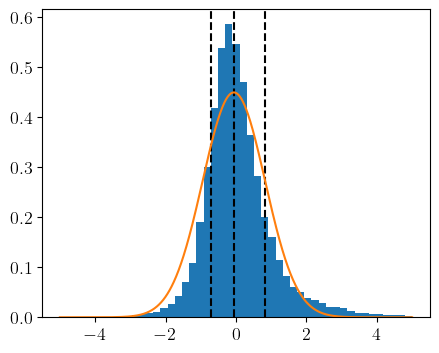

In [8]:
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(5, 4))

mask = is_qso & is_LAE & nice_lya & nice_z & (L_lya > 43.2)

to_hist = ((L_Arr - L_lya) / L_e_Arr_plus)[mask]
ax.hist(to_hist, np.linspace(-5, 5), density=True)
to_hist_perc = np.nanpercentile(to_hist, [16, 50, 84])
for x in to_hist_perc:
    ax.axvline(x, ls='--', c='k')
L_median = to_hist_perc[1]
L_std = (to_hist_perc[2] - to_hist_perc[1])
xx = np.linspace(-5, 5, 1000)
ax.plot(xx, norm.pdf(xx, L_median, L_std))
print(f'median = {L_median:0.2f}, std = {L_std:0.2f}')

plt.show()

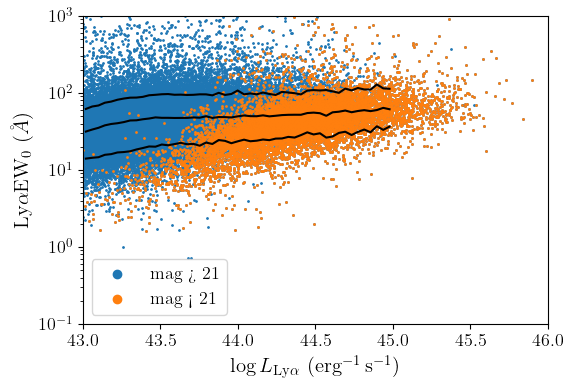

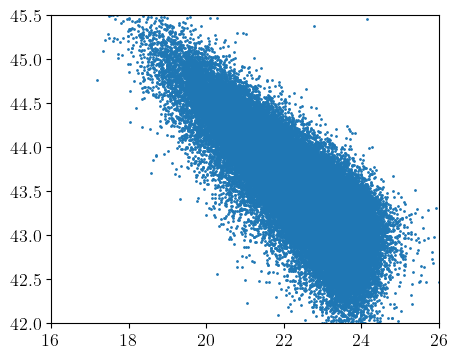

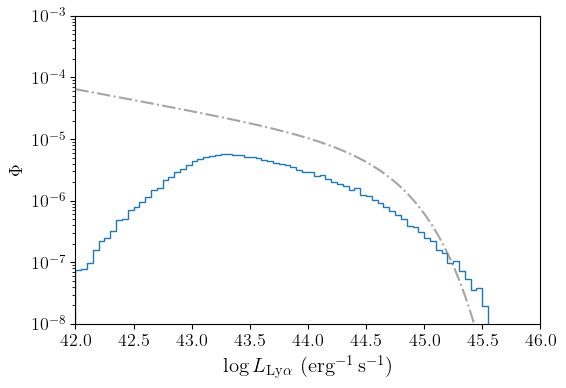

In [19]:
L_bins = np.linspace(43, 45, 50)
bc = bin_centers(L_bins)

percs = []
for i in range(len(L_bins) - 1):
    mask = (L_lya > L_bins[i]) & (L_lya <= L_bins[i + 1])
    percs.append(np.nanpercentile(EW_lya[mask], [10, 50, 90]))

percs = [[0, 0, 0] if np.any(np.isnan(item)) else item for item in percs]
percs = np.array(percs)

fig, ax = plt.subplots(figsize=(6, 4))

mask = is_qso & is_LAE
ax.plot(L_lya[mask], EW_lya[mask], ls='', marker='.', markersize=2)
ax.plot(L_lya[mask & (mag < 21)], EW_lya[mask & (mag < 21)], ls='', marker='.',
        markersize=2)
mask = mask & nice_lya & nice_z
ax.scatter(-99, -99, color='C0', label='mag > 21')
ax.scatter(-99, -99, color='C1', label='mag < 21')
ax.plot(bc, percs[:, 1], color='k')
ax.plot(bc, percs[:, 0], color='k')
ax.plot(bc, percs[:, 2], color='k')
ax.set_yscale('log')
ax.set_ylim(1e-1, 1e3)
ax.set_xlim(43, 46)
ax.set_xlabel(r'$\log L_{\mathrm{Ly}\alpha}$ (erg$^{-1}\,$s$^{-1}$)', fontsize=15)
ax.set_ylabel(r'Ly$\alpha$EW$_0$ ($\AA$)', fontsize=15)
ax.legend()

plt.show()

fig, ax = plt.subplots(figsize=(5, 4))

mask = is_qso & is_LAE
ax.plot(mag[mask], L_lya[mask], ls='', marker='o', markersize=1)
ax.set_ylim(42, 45.5)
ax.set_xlim(16, 26)

plt.show()

fig, ax = plt.subplots(figsize=(6, 4))

bins = np.arange(42, 46, 0.05)
bin_w = bins[1] - bins[0]
volume = z_volume(z_min, z_max, 400)
mask = is_qso & is_LAE & (mag < 24)
ax.hist(L_lya[mask], bins,
        weights=np.full(sum(mask), (volume * bin_w) ** -1),
        histtype='step')

# Plot the reference LF curves
Lx = np.logspace(42, 46, 10000)
phistar1 = 3.33e-6
Lstar1 = 10 ** 44.65
alpha1 = -1.35

Phi_center = schechter(
    Lx, phistar1, Lstar1, alpha1
) * Lx * np.log(10)

ax.plot(
    np.log10(Lx), Phi_center, ls='-.', alpha=0.7,
    label='Spinoso2020 ($z=2.2-3.25$)', zorder=51,
    color='C7'
)
ax.set_yscale('log')
ax.set_ylim(1e-8, 1e-3)
ax.set_xlim(42, 46)
ax.set_xlabel(r'$\log L_{\mathrm{Ly}\alpha}$ (erg$^{-1}\,$s$^{-1}$)', fontsize=15)
ax.set_ylabel(r'$\Phi$')

plt.show()

In [10]:
mask = (mag > 0) & (z_Arr < 66) & (L_Arr > 40) & (lya_lines >= 1) & (lya_lines <= 4)
print(f'Gal = {sum(is_gal & nice_lya & mask) / gal_area:0.1f}')
print(f'Good QSO = {sum(is_qso & nice_lya & nice_z & mask & is_LAE) / good_qso_area:0.1f}')
print(f'Bad QSO = {sum(is_qso & nice_lya & ~is_LAE & mask) / bad_qso_area:0.1f}')
print(f'Bad (good) QSO = {sum(is_qso & nice_lya & ~nice_z & mask & is_LAE) / good_qso_area:0.1f}')
print(f'SF = {sum(is_sf & nice_lya & mask) / sf_area:0.1f}')

Gal = 54.3
Good QSO = 36.6
Bad QSO = 15.4
Bad (good) QSO = 0.1
SF = 15.3


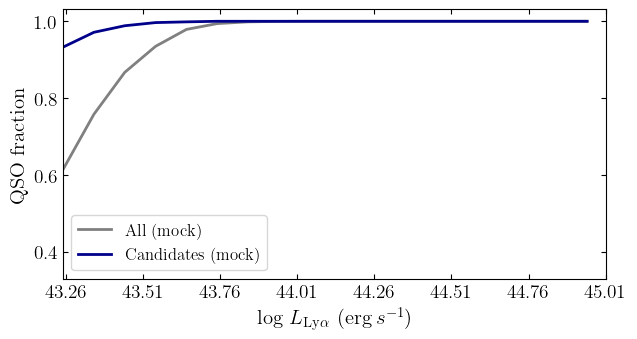

In [11]:
fig, ax = plt.subplots(figsize=(7, 3.5))

bins = np.linspace(43, 45, 21)
b_c = [bins[i: i + 2].sum() * 0.5 for i in range(len(bins) - 1)]

h_sf = np.histogram(L_Arr[nice_lya & nice_z & is_sf], bins)[0]
h_qso = np.histogram(L_Arr[nice_lya & nice_z & is_qso], bins)[0] * good_qso_factor

h_sf_mock = np.histogram(L_lya[zspec_cut & is_sf], bins)[0]
h_qso_mock = np.histogram(L_lya[zspec_cut & is_qso], bins)[0] * good_qso_factor

ax.plot(b_c, h_qso_mock / (h_qso_mock + h_sf_mock), linewidth=2, color='gray', label='All (mock)')
ax.plot(b_c, h_qso / (h_qso + h_sf), linewidth=2, color='darkblue', label='Candidates (mock)')

ax.set_xlim(43.25, 45)

ax.set_ylabel('QSO fraction', fontsize=15)
ax.set_xlabel(r'log $L_{\mathrm{Ly}\alpha}$ (erg$\,s^{-1}$)', fontsize=15)

ax.tick_params(labelsize=14, direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xticks(np.arange(43.26, 45.25, 0.25))

ax.legend(fontsize=12)

fig.savefig(f'figures/QSO_fraction.pdf', bbox_inches='tight',
            facecolor='w', edgecolor='w')
plt.show()

Selected = 1953

111600
zspec = 1.63, z_Arr = 2.29
r = 22.10
EW_lya = 0.00
L_Arr = 43.51
L_lya = -0.85
EW_Arr = 60.16
g-r = 0.01, r-i = 0.13
r = 22.097856516436828
QSO


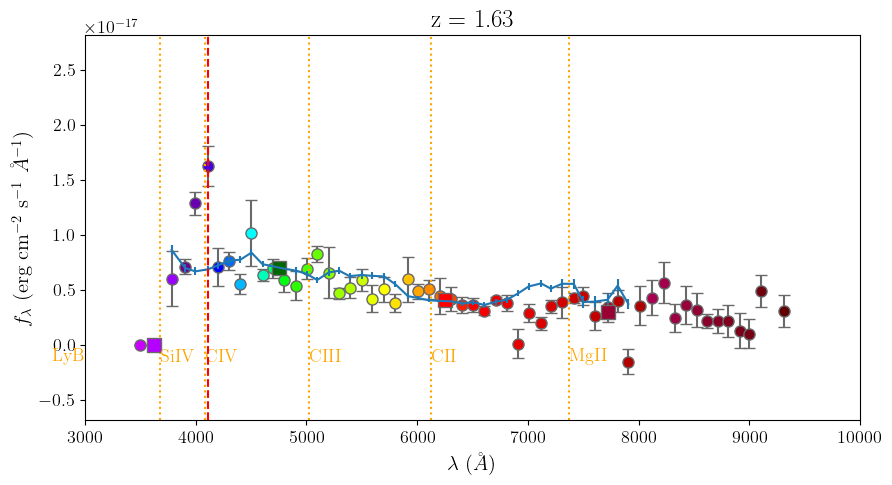

105235
zspec = 1.73, z_Arr = 2.46
r = 19.70
EW_lya = 0.00
L_Arr = 44.66
L_lya = 0.81
EW_Arr = 72.69
g-r = 0.07, r-i = 0.43
r = 19.699565175806747
QSO


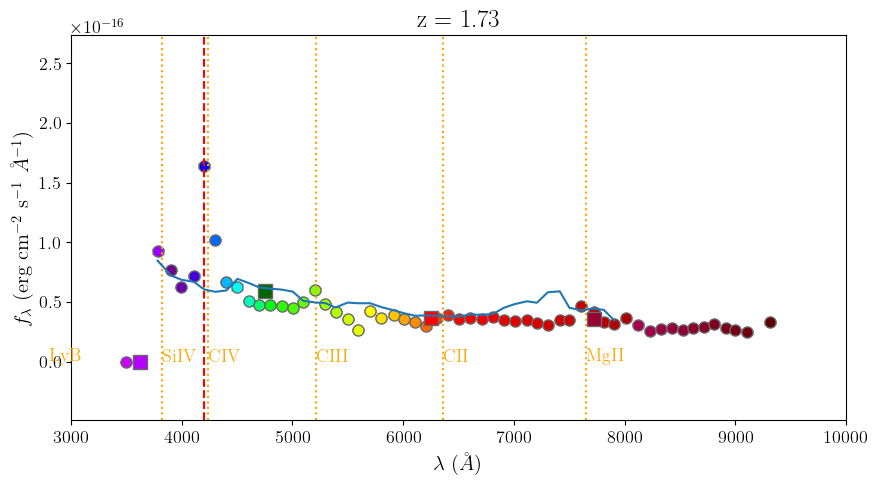

111874
zspec = 1.72, z_Arr = 2.46
r = 20.70
EW_lya = 0.00
L_Arr = 44.32
L_lya = 0.50
EW_Arr = 66.76
g-r = -0.12, r-i = 0.44
r = 20.699583488715696
QSO


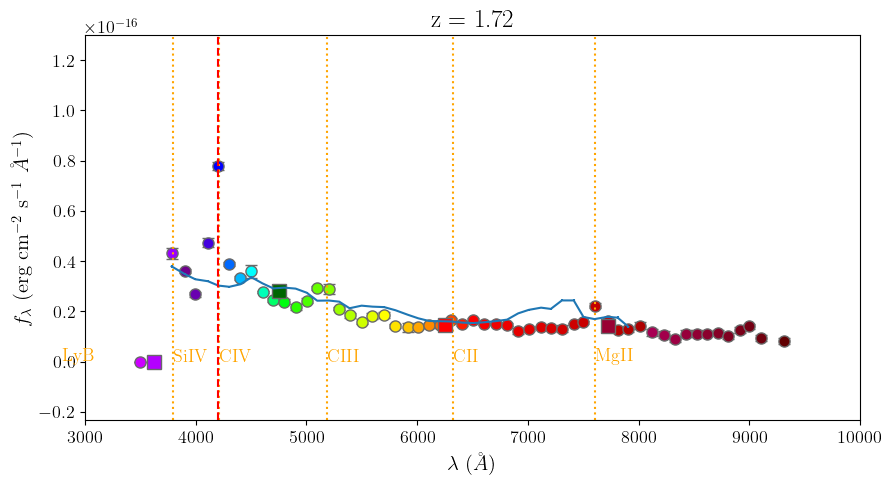

114526
zspec = 1.73, z_Arr = 2.46
r = 21.73
EW_lya = 0.00
L_Arr = 43.82
L_lya = -0.17
EW_Arr = 78.77
g-r = 0.10, r-i = 0.39
r = 21.734143168679317
QSO


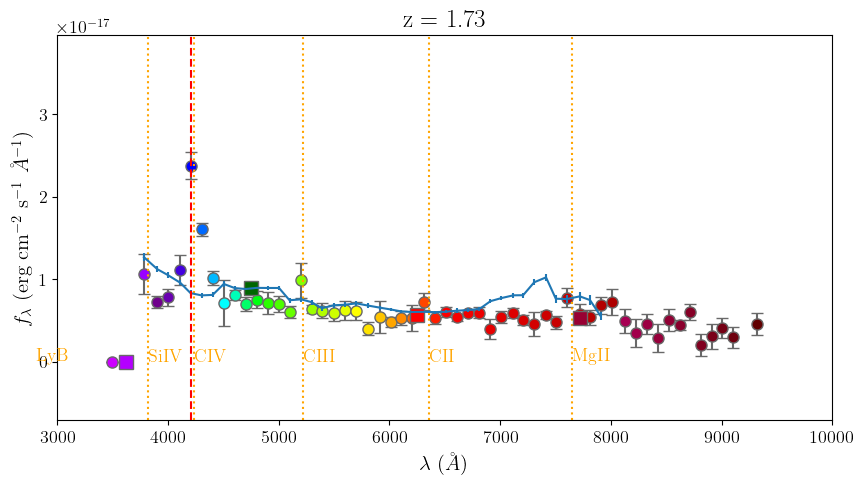

116758
zspec = 1.77, z_Arr = 2.54
r = 21.32
EW_lya = 0.00
L_Arr = 43.76
L_lya = -0.43
EW_Arr = 46.22
g-r = 0.30, r-i = 0.57
r = 21.319146461407435
QSO


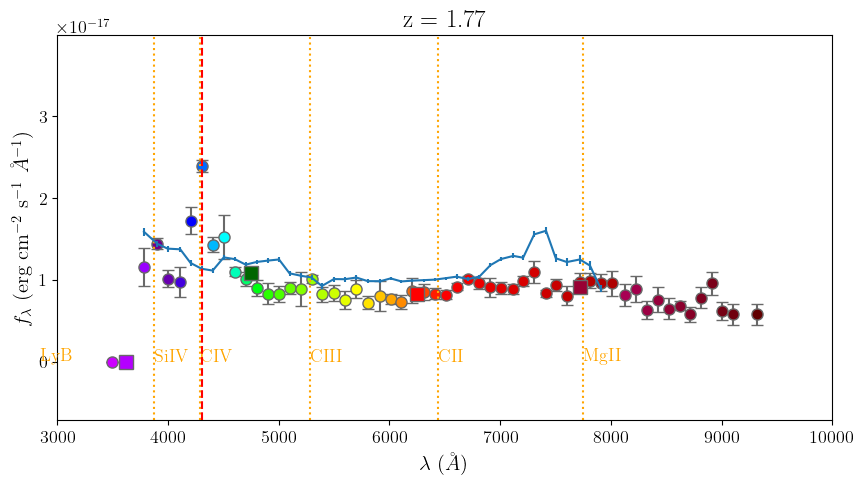

113199
zspec = 1.64, z_Arr = 2.29
r = 20.71
EW_lya = 0.00
L_Arr = 44.06
L_lya = 0.43
EW_Arr = 44.94
g-r = -0.08, r-i = 0.17
r = 20.714461683904638
QSO


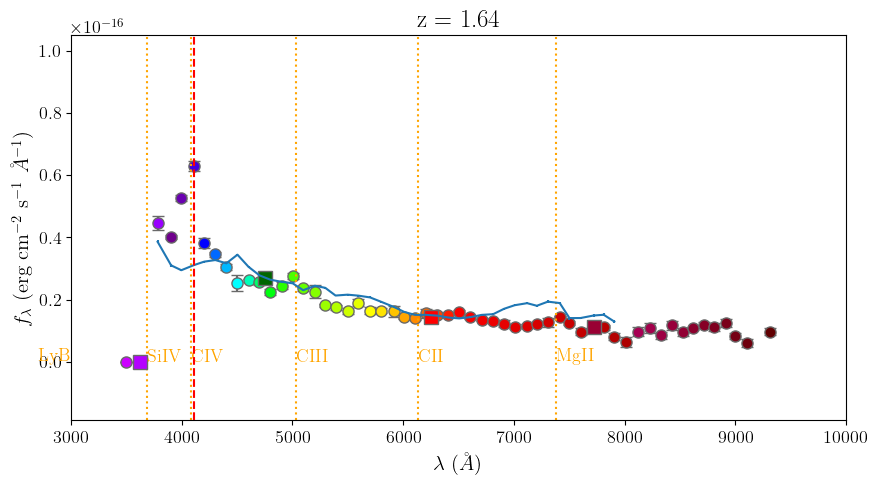

105322
zspec = 1.63, z_Arr = 2.29
r = 21.64
EW_lya = 0.00
L_Arr = 43.57
L_lya = -0.14
EW_Arr = 48.49
g-r = 0.23, r-i = 0.40
r = 21.63952144075727
QSO


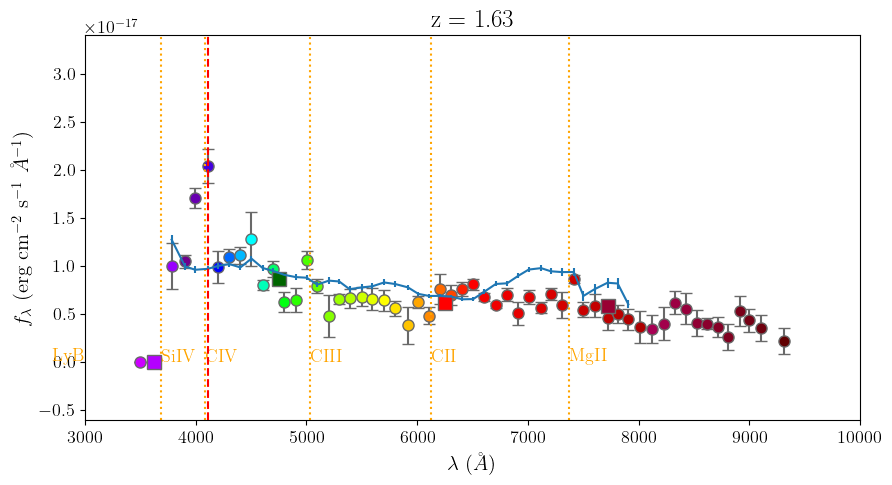

106266
zspec = 1.68, z_Arr = 2.38
r = 22.29
EW_lya = 0.00
L_Arr = 43.51
L_lya = -0.84
EW_Arr = 68.32
g-r = 0.12, r-i = 0.34
r = 22.29485027031908
QSO


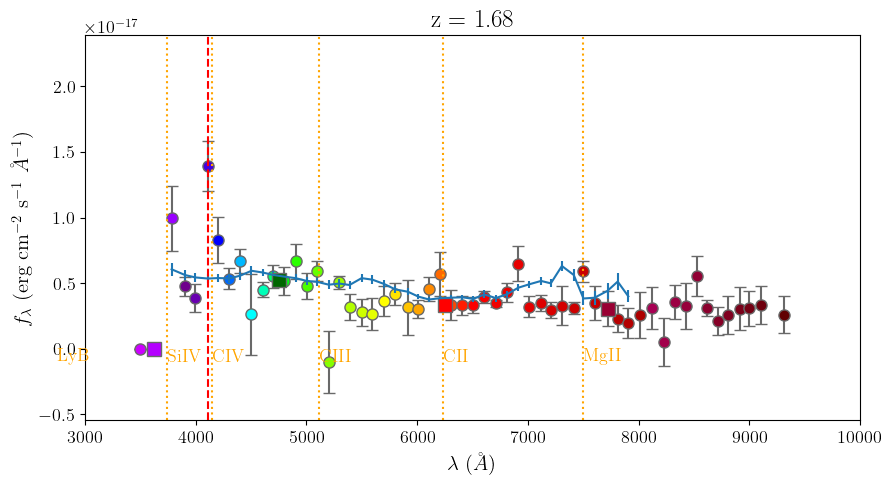

112402
zspec = 1.61, z_Arr = 2.21
r = 22.25
EW_lya = 0.00
L_Arr = 43.36
L_lya = -0.67
EW_Arr = 73.23
g-r = 0.26, r-i = 0.35
r = 22.254569345969678
QSO


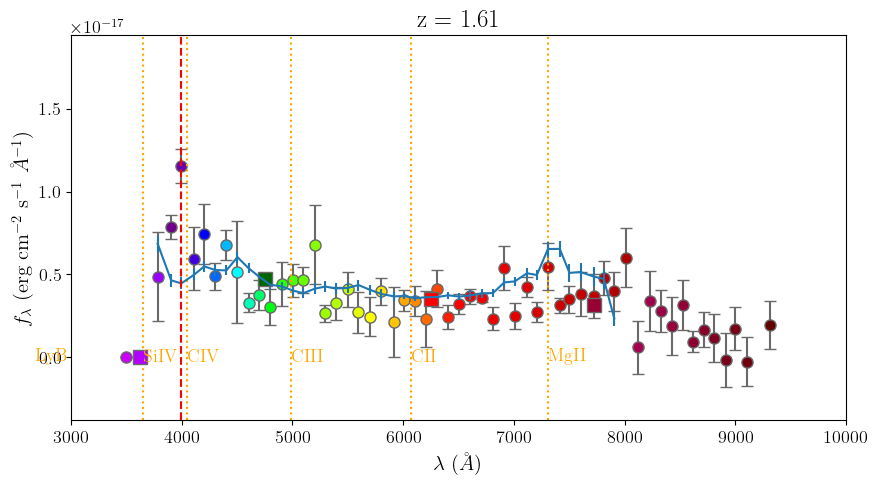

108980
zspec = 1.64, z_Arr = 2.38
r = 20.50
EW_lya = 0.00
L_Arr = 43.98
L_lya = -0.39
EW_Arr = 39.02
g-r = 0.19, r-i = 0.34
r = 20.49651642786774
QSO


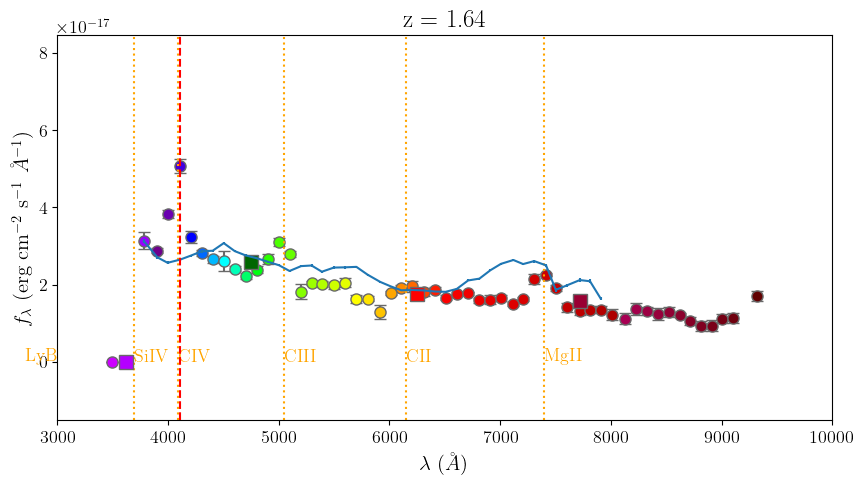

In [12]:
selected = np.random.permutation(
    np.where(
        is_qso & nice_lya & (zspec < 1.8) & (zspec > 1.6)
    )[0]
)
print(f'Selected = {len(selected)}\n')

qso_lines = [1025.7220, 1397.61, 1549.48, 1908.73, 2799.12, 2326, 3727]
qso_lines_name = ['LyB', 'SiIV', 'CIV', 'CIII', 'MgII', 'CII', 'OII']
# Actually gal lines
# qso_lines = [3727, 4861, 5007, 6549, 6585]
# qso_lines_name = ['OII', r'H$\beta$', 'OIII', r'H$\alpha$']
pm_flx[0, :] = 0
pm_flx[-4, :] = 0
pm_err[0, :] = 0
pm_err[-4, :] = 0

ii = flux_to_mag(pm_flx[-1], w_central[-1])
rr = flux_to_mag(pm_flx[-2], w_central[-2])
gg = flux_to_mag(pm_flx[-3], w_central[-3])
ri = rr - ii
gr = gg - rr

for i, src in enumerate(selected):
    if i == 10:
        break
    print(src)
    print(f'zspec = {zspec[src]:0.2f}, z_Arr = {z_Arr[src]:0.2f}')
    print(f'r = {mag[src]:0.2f}')
    print(f'EW_lya = {EW_lya[src]:0.2f}')
    print(f'L_Arr = {L_Arr[src]:0.2f}')
    print(f'L_lya = {L_lya[src]:0.2f}')
    print(f'EW_Arr = {EW_nb_Arr[src]:0.2f}')
    print(f'g-r = {(gg-rr)[src]:0.2f}, r-i = {(rr-ii)[src]:0.2f}')
    print(f'r = {mag[src]}')
    lya_obs_w = w_central[lya_lines[src]]
    other_lines_w = [w_central[i] for i in other_lines[src]]
    lya_real_w = w_lya * (1 + zspec[src])

    fig = plt.figure(figsize=(10, 5))
    ax = plot_JPAS_source(pm_flx[:, src], pm_err[:, src]) 

    ax.axvline(lya_obs_w, linestyle='--', color='r', label='Retrieved Lya line', zorder=999)
    # ax.axvline(lya_real_w, color='g', label='Real Lya line')
    # for w in other_lines_w:
    #     ax.axvline(w, linestyle='--', color='dimgray')
    for name, w in zip(qso_lines_name, qso_lines):
        qso_obs_w = w * (1 + zspec[src])
        if qso_obs_w > 9100:
            continue
        ax.axvline(qso_obs_w, linestyle=':', color='orange')
        # ypos = pm_flx_line[:, np.where(gal_src == src)[0][0]].min() * 1e17
        ypos = pm_flx[:, src].min()
        ax.text(qso_obs_w, ypos, name, color='orange')
    if is_qso[src]:
        print('QSO')
    elif is_gal[src]:
        print('GAL')
    elif is_sf[src]:
        print('SF')
    else:
        print('WTF?')

    ax.errorbar(w_central[1:43], cont_est_lya[1:-13, src], yerr=cont_err_lya[1:-13, src])
    # ax.errorbar(w_central[1:53] + 6, cont_est_lya_3fm[1:-3, src], yerr=cont_err_lya_3fm[1:-3, src])
    # ax.plot(w_central[1:43], cont_est_other[1:-13, src], ls='--')

    ax.set_title(f'zspec={zspec[src]:0.3f}, z_Arr={z_Arr[src]:0.3f}')

    # ax.set_ylim((-0.25, 5))
    ax.set_xlim((3000, 10000))
    ax.set_title(f'z = {zspec[src]:0.2f}', fontsize=18)

    plt.show()

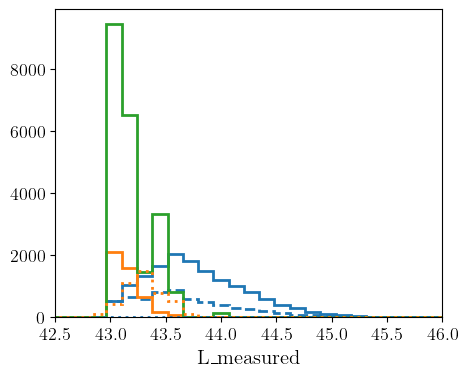

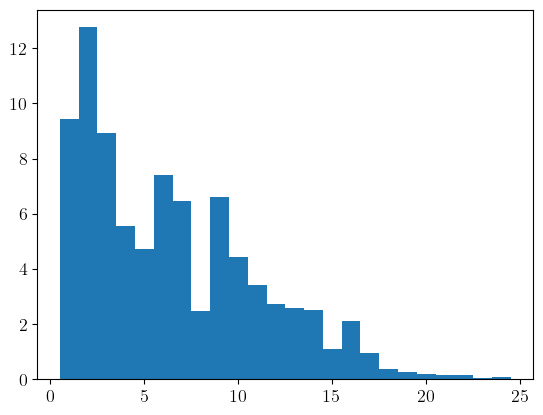

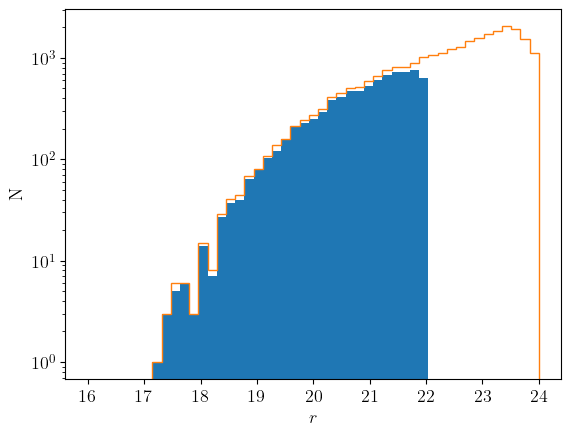

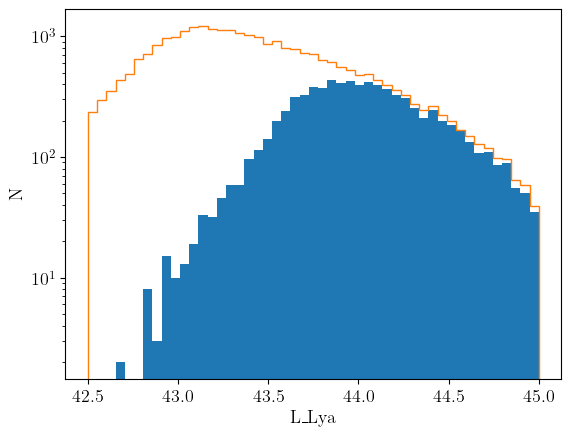

In [26]:
def do_this():
    fig, ax = plt.subplots(figsize=(5, 4))

    mask = (lya_lines >= 1) & (lya_lines <= 4)

    where = nice_lya & is_qso & nice_z & mask & is_LAE
    bins = np.linspace(42, 46, 30)
    to_hist = L_Arr[where]
    h_qso_LAE, _ = ax.hist(to_hist, bins, histtype='step', linewidth=2,
            weights=np.full(to_hist.shape, good_qso_factor), color='C0')[:2]

    where = (nice_lya & is_qso & ~nice_z) & mask & ~is_LAE
    to_hist = L_Arr[where]
    h_qso_cont, _ = ax.hist(to_hist, bins, histtype='step', linewidth=2,
                       weights=np.full(to_hist.shape, 1), color='C0', ls='--')[:2]

    where = (nice_lya & is_sf & nice_z) & mask & (EW_lya > 30)
    to_hist = L_Arr[where]
    h_sf, _ = ax.hist(to_hist, bins, histtype='step',
            linewidth=2, weights=np.full(to_hist.shape, sf_factor), color='C1')[:2]

    where = (nice_lya & is_gal) & mask
    to_hist = L_Arr[where]
    h_gal, _ = ax.hist(to_hist, bins, histtype='step',
            linewidth=2, weights=np.full(to_hist.shape, gal_factor), color='C2')[:2]

    where = nice_lya & is_qso & ~nice_z & mask & is_LAE
    bins = np.linspace(42, 46, 30)
    to_hist = L_Arr[where]
    h_qso_LAE, _ = ax.hist(to_hist, bins, histtype='step', linewidth=2,
            weights=np.full(to_hist.shape, good_qso_factor), color='C0',
            linestyle=':')[:2]

    where = (nice_lya & is_sf & nice_z) & mask & (EW_lya > 30)
    to_hist = L_lya[where]
    h_sf, _ = ax.hist(to_hist, bins, histtype='step',
            linewidth=2, weights=np.full(to_hist.shape, sf_factor), color='C1',
            linestyle=':')[:2]

    ax.set_xlabel('L_measured', fontsize=15)
    ax.set_xlim(42.5, 46)
#     ax.set_yscale('log')

    plt.show()
    
    fig, ax = plt.subplots()

    mask = nice_lya & is_qso & nice_lya & nice_z
    ax.hist(lya_lines[mask], np.arange(0.5, 25.5, 1),
            weights=np.full(sum(mask), good_qso_area**-1))

    plt.show()

    fig, ax = plt.subplots()

    bins = np.linspace(16, 24, 50)
    
    this_nb_min, this_nb_max = 1, 4
    this_mask = (lya_lines >= this_nb_min) & (lya_lines <= this_nb_max)
    this_z_min = (w_central[this_nb_min] - nb_fwhm_Arr[this_nb_min] * 0.5) / w_lya - 1
    this_z_max = (w_central[this_nb_max] + nb_fwhm_Arr[this_nb_max] * 0.5) / w_lya - 1
    this_zspec_cut = (zspec > this_z_min) & (zspec <= this_z_max)

    ax.hist(mag[is_qso & is_LAE & nice_z & nice_lya & this_mask], bins)
    ax.hist(mag[is_qso & is_LAE & this_zspec_cut], bins, histtype='step')
    ax.set_xlabel('$r$')
    ax.set_ylabel('N')
    ax.set_yscale('log')

    plt.show()

    fig, ax = plt.subplots()

    bins = np.linspace(42.5, 45, 50)
    ax.hist(L_lya[is_qso & is_LAE & nice_z & nice_lya & this_mask], bins)
    ax.hist(L_lya[is_qso & is_LAE & this_zspec_cut], bins, histtype='step')
    ax.set_xlabel('L_Lya')
    ax.set_ylabel('N')
    ax.set_yscale('log')

    plt.show()
    
do_this()

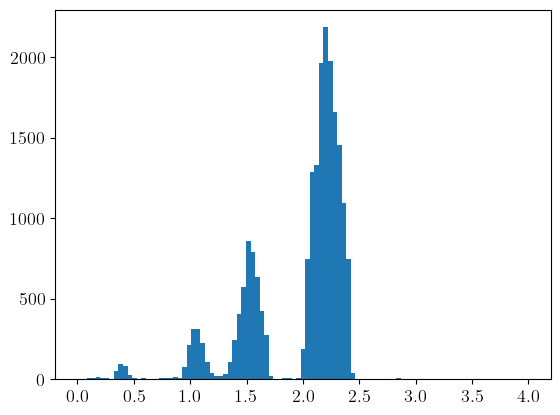

In [14]:
mask = (lya_lines >= 1) & (lya_lines <= 4)
plt.hist(zspec[is_qso & nice_lya & mask], np.linspace(0, 4, 100))
plt.show()

In [15]:
def contour_curve(xx, yy, bins_xx, bins_yy):
    Z, x, y = np.histogram2d(xx, yy, bins=(bins_xx, bins_yy))

    H_min = np.amin(Z)
    H_max = np.amax(Z)

    y_centers = 0.5 * (y[1:] + y[:-1])
    x_centers = 0.5 * (x[1:] + x[:-1])

    N_bins = 10000

    H_Arr = np.linspace(H_min, H_max, N_bins)[::-1]

    fact_up_Arr = np.zeros(N_bins)

    TOTAL_H = np.sum(Z)

    for iii in range(0, N_bins):

        mask = Z > H_Arr[iii]

        fact_up_Arr[iii] = np.sum(Z[mask]) / TOTAL_H

    H_value_68 = np.interp(0.683, fact_up_Arr, H_Arr)  # 1sigma
    H_value_95 = np.interp(0.954, fact_up_Arr, H_Arr)  # 2sigma
    H_value_90 = np.interp(0.900, fact_up_Arr, H_Arr)  # 2sigma
    H_value_99 = np.interp(0.997, fact_up_Arr, H_Arr)  # 2sigma
    # levels = [H_value_99]
    levels = [H_value_95, H_value_68]

    return x_centers, y_centers, Z.T, levels


In [16]:
def compute_EW_bin_err(EW_Arr, EW_lya, EW_binning):
    '''
    Computes the errors due to dispersion of L_retrieved with some L_retrieved binning
    '''
    EW_bin_err_plus = np.ones(len(EW_binning) - 1) * 99
    EW_bin_err_minus = np.ones(len(EW_binning) - 1) * 99
    median = np.ones(len(EW_binning) - 1) * 99
    last = [0., 0.]
    for i in range(len(EW_binning) - 1):
        in_bin = (EW_Arr >= EW_binning[i]) & (EW_Arr < EW_binning[i + 1])
        if count_true(in_bin) == 0:
            EW_bin_err_plus[i] = last[0]
            EW_bin_err_minus[i] = last[1]
            continue
        perc = np.nanpercentile((EW_Arr - EW_lya)[in_bin], [16, 50, 84])
        EW_bin_err_plus[i] = perc[2] - perc[1]

        last = [EW_bin_err_plus[i], EW_bin_err_minus[i]]
        median[i] = perc[1]

    return EW_bin_err_plus, median
    
# Apply bin err
EW_binning = np.linspace(0, 50, 50)
EW_bin_c = [EW_binning[i: i + 2].sum() * 0.5 for i in range(len(EW_binning) - 1)]
Lmask = nice_z & nice_lya
EW_bin_err, median_EW = compute_EW_bin_err(EW_nb_Arr[Lmask], EW_lya[Lmask], EW_binning)
EW_binning_position = binned_statistic(EW_nb_Arr, None, 'count',
                                       bins=EW_binning).binnumber
EW_binning_position[EW_binning_position > len(EW_binning) - 2] = len(EW_binning) - 2
EW_Arr_err_new = EW_bin_err[EW_binning_position]
EW_Arr_new = EW_nb_Arr - np.interp(EW_nb_Arr, np.log10(EW_bin_c), median_EW)

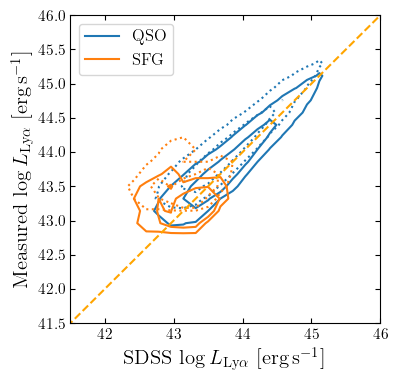

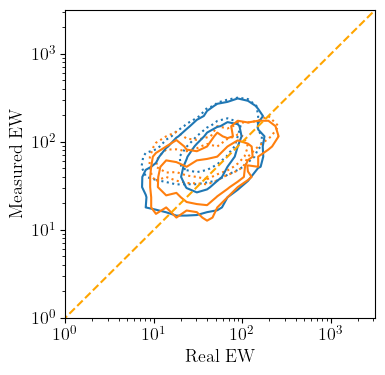

In [17]:
L_bins = np.linspace(40, 47, 40)

fig, ax = plt.subplots(figsize=(4, 4))

mask = (lya_lines >= 1) & (lya_lines <= 8)
xx, yy, Z, levels = contour_curve(
    L_lya[is_qso & nice_lya & mask], L_Arr[is_qso & nice_lya & mask], L_bins, L_bins)
ax.contour(xx, yy, Z, levels, colors='C0')
xx, yy, Z, levels = contour_curve(
    L_lya[is_qso & nice_lya & mask], L_Arr_uncorr[is_qso & nice_lya & mask], L_bins, L_bins)
ax.contour(xx, yy, Z, levels, colors='C0', linestyles=':')
xx, yy, Z, levels = contour_curve(
    L_lya[is_sf & nice_lya], L_Arr[is_sf & nice_lya], L_bins, L_bins)
ax.contour(xx, yy, Z, levels, colors='C1')
xx, yy, Z, levels = contour_curve(
    L_lya[is_sf & nice_lya], L_Arr_uncorr[is_sf & nice_lya], L_bins, L_bins)
ax.contour(xx, yy, Z, levels, colors='C1', linestyles=':')
ax.plot([30, 100], [30, 100], c='orange', ls='--')

# Dummies for legend
ax.plot(0, 0, c='C0', label='QSO')
ax.plot(0, 0, c='C1', label='SFG')

ax.set_ylim(41.5, 46)
ax.set_xlim(41.5, 46)
ax.legend(fontsize=12)
ax.tick_params(direction='in', which='both', labelsize=11)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_axisbelow(False)
ax.set_ylabel(r'Measured $\log L_{\mathrm{Ly}\alpha}$ [erg$\,$s$^{-1}$]', fontsize=15)
ax.set_xlabel(r'SDSS $\log L_{\mathrm{Ly}\alpha}$ [erg$\,$s$^{-1}$]', fontsize=15)

plt.savefig('figures/L_real_vs_ret.pdf',
    bbox_inches='tight', facecolor='w', edgecolor='w')
plt.show()

fig, ax = plt.subplots(figsize=(4, 4))

EW_bins = np.logspace(-1, 3.5, 40)

xx, yy, Z, levels = contour_curve(
    EW_lya[is_qso & nice_lya & mask], EW_nb_Arr[is_qso & nice_lya & mask], EW_bins, EW_bins)
ax.contour(xx, yy, Z, levels, colors='C0', linestyles=':')
xx, yy, Z, levels = contour_curve(
    EW_lya[is_sf & nice_lya], EW_nb_Arr[is_sf & nice_lya], EW_bins, EW_bins)
ax.contour(xx, yy, Z, levels, colors='C1', linestyles=':')
xx, yy, Z, levels = contour_curve(
    EW_lya[is_qso & nice_lya & mask], EW_Arr_new[is_qso & nice_lya & mask], EW_bins, EW_bins)
ax.contour(xx, yy, Z, levels, colors='C0')
xx, yy, Z, levels = contour_curve(
    EW_lya[is_sf & nice_lya], EW_Arr_new[is_sf & nice_lya], EW_bins, EW_bins)
ax.contour(xx, yy, Z, levels, colors='C1')
ax.plot([1e-2, 1e5], [1e-2, 1e5], c='orange', ls='--')

ax.set_xlabel('Real EW')
ax.set_ylabel('Measured EW')

ax.set_ylim(1e0, 10**3.5)
ax.set_xlim(1e0, 10**3.5)
ax.set_yscale('log')
ax.set_xscale('log')

plt.show()

In [22]:
from minijpas_LF_and_puricomp import LF_perturb_err

starprob = np.ones_like(L_Arr)
tile_id = np.ones_like(L_Arr) * 2241
L_binning = np.load('npy/L_nb_err_binning.npy')
bins = np.log10(L_binning)
bw = bins[1] - bins[0]

this_nb_min, this_nb_max = 8, 12
this_z_min = (w_central[this_nb_min] - nb_fwhm_Arr[this_nb_min] * 0.5) / w_lya - 1
this_z_max = (w_central[this_nb_max] + nb_fwhm_Arr[this_nb_max] * 0.5) / w_lya - 1
general_mask = (lya_lines >= this_nb_min) & (lya_lines <= this_nb_max)
class_list = [
    [is_gal & general_mask, gal_factor],
    [is_sf & general_mask, sf_factor],
    [is_qso & general_mask & ~is_LAE, 1.],
    [is_qso & is_LAE & general_mask, good_qso_factor]
]

folder_name = f'LF_r17-24_nb{this_nb_min}-{this_nb_max}_ew30_ewoth100_nb_1.0'
dirname = f'/home/alberto/cosmos/LAEs/Luminosity_functions/{folder_name}'

hist_mat = None
hist_i_mat_list = []
for [mask, class_factor] in class_list:
    L_e_Arr_pm = [L_Lbin_err_minus[L_binning_position][mask],
                L_Lbin_err_plus[L_binning_position][mask]]
    hist_i_mat =\
        LF_perturb_err(corr_L[mask] * 0, L_Arr[mask], L_e_Arr_pm, nice_lya[mask], mag[mask],
                    z_Arr[mask], starprob[mask], bins, 'minijpasAEGIS001', tile_id[mask],
                    return_puri=True, dirname=dirname, return_hist_i_mat=True,
                    N_iter=1, save_hist_i_mat=False)

    if hist_mat is None:
        hist_mat = hist_i_mat * class_factor
    else:
        hist_mat = hist_mat + hist_i_mat * class_factor
    hist_i_mat_list.append(hist_i_mat)

vol = z_volume(this_z_min, this_z_max, bad_qso_area)
L_LF_err_percentiles = np.percentile(hist_mat, [16, 50, 84], axis=0)
L_LF_err_plus = (L_LF_err_percentiles[2] - L_LF_err_percentiles[1]) / vol / bw
L_LF_err_minus = (L_LF_err_percentiles[1] - L_LF_err_percentiles[0]) / vol / bw
hist_median = L_LF_err_percentiles[1] / vol / bw

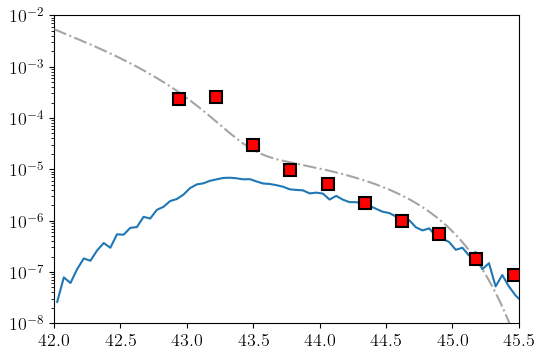

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the reference LF curves
Lx = np.linspace(10 ** 42, 10 ** 46, 10000)
phistar1 = 3.33e-6
Lstar1 = 44.65
alpha1 = -1.35
phistar2 = -3.45
Lstar2 = 42.93
alpha2 = -1.93

Phi_center = double_schechter(
    Lx, phistar1, 10 ** Lstar1, alpha1, 10 ** phistar2, 10 ** Lstar2, alpha2
) * Lx * np.log(10)

ax.plot(
    np.log10(Lx), Phi_center, ls='-.', alpha=0.7,
    label='Spinoso2020 ($z=2.2-3.25$)', zorder=51,
    color='C7'
)
bins2 = np.arange(42, 46, 0.05)
bin_w = bins2[1] - bins2[0]
volume = z_volume(this_z_min, this_z_max, good_qso_area)
zspec_cut = (zspec > this_z_min) & (zspec < this_z_max)
h_mask = is_qso & is_LAE & (EW_lya + EW_NV > 30) & zspec_cut
h, b = np.histogram(L_lya[h_mask], bins2,
        weights=np.full(sum(h_mask), (volume * bin_w) ** -1))
ax.plot(bin_centers(b), h)
bc = bin_centers(bins)
ax.errorbar(bc, hist_median,
            yerr=[L_LF_err_minus, L_LF_err_plus],
            linestyle='', fmt='s',
            ecolor='k', markeredgecolor='k', markerfacecolor='red',
            markeredgewidth=1.5, markersize=8,
            capsize=4, zorder=99)

ax.set_yscale('log')
ax.set_xlim(42, 45.5)
ax.set_ylim(1e-8, 1e-2)

plt.show()